In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import os
from copy import deepcopy
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

import random
import math
import scipy.stats as stats
import scipy.signal
from scipy.stats import spearmanr, pearsonr
from sklearn import preprocessing
from tqdm import tqdm, trange
import pickle
from itertools import product
from collections import OrderedDict
import torch
import torch.nn.functional as F
seed = 1337
random.seed(seed)
np.random.seed(seed)
import matplotlib
import matplotlib as mpl
import torch.nn as nn

In [2]:
import argparse
from argparse import Namespace
from collections import Counter
parser = argparse.ArgumentParser()

parser.add_argument('--filename', type = str, default = './ESM2_finetuned/attentions_symm/Finetuned_4.1_train__CVESM2lr1e-5_ESM2SISS_FS4.1.ep93.1e-2.dr2_unmod_1_10folds_rl_LabelScalerFalse_LabelLog2False_AvgEmbFalse__attentions_symm.npz')
parser.add_argument('--ngrams', type = int, default = 8)
parser.add_argument('--ratio', action = 'store_true')
args = parser.parse_args([])
print(args)

global obj_col, seed
out_filename = f'SHAP_{args.ngrams}grams__' + '__'.join(args.filename.split('__')[1:3])
print(out_filename)

Namespace(filename='./ESM2_finetuned/attentions_symm/Finetuned_4.1_train__CVESM2lr1e-5_ESM2SISS_FS4.1.ep93.1e-2.dr2_unmod_1_10folds_rl_LabelScalerFalse_LabelLog2False_AvgEmbFalse__attentions_symm.npz', ngrams=8, ratio=False)
SHAP_8grams__CVESM2lr1e-5_ESM2SISS_FS4.1.ep93.1e-2.dr2_unmod_1_10folds_rl_LabelScalerFalse_LabelLog2False_AvgEmbFalse__attentions_symm.npz


In [3]:
def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

def performances(label, pred):
    
    r = r2(label, pred)
    pearson_r = pearsonr(label, pred)[0]
    sp_cor = spearmanr(label, pred)[0]
    print(f'r-squared = {r:.4f} | pearson r = {pearson_r:.4f} | spearman R = {sp_cor:.4f}')
            
    return [r, pearson_r, sp_cor]

In [4]:
def kmers_list(ngrams = 3):
    kmers = list('AGCT')
    for i in trange(1, ngrams):
        kmers = [''.join(c) for c in list(product(kmers, 'AGCT'))]
        print(f'{i+1}-mers: {len(kmers)}')
    return kmers

In [5]:
def generate_seqs_kmers_contacts_pd(data, kmers):
    seqs_kmers_contacts_pd = pd.DataFrame()
    i = 0
    for seq, attention_contacts in tqdm(zip(data['sequences'], data[obj_col])):
        seq = seq.replace('<pad>', '')
        attention_contacts = attention_contacts[:len(seq), :len(seq)]

        if args.ratio:
            attention_contrib_ratio = F.softmax(torch.Tensor(attention_contacts), dim = 0) # 列相加=1
            seq_contrib_ratio = np.array(attention_contrib_ratio.sum(axis = 1))

            temp_dict = create_ngram_list(seq, len(kmers[0]), seq_contrib_ratio, kmers)
        else:
            seq_contact_scores = attention_contacts.sum(axis = 1)

            temp_dict = create_ngram_list(seq, len(kmers[0]), seq_contact_scores, kmers)

        if i == 0: 
            seq_kmers_dict = deepcopy(temp_dict)
            i += 1
        else:
            seq_kmers_dict = dict(Counter(seq_kmers_dict) + Counter(temp_dict))
    
    return seq_kmers_dict

In [6]:
def create_ngram_list(seq, ngrams, contact_scores, kmers_list):
    kmers_dict = OrderedDict(zip(kmers_list, [0]*len(kmers_list)))
    
    if len(seq) >= ngrams:
        mer = zip(*[seq[i:] for i in range(ngrams)])
        con = zip(*[contact_scores[i:] for i in range(ngrams)])
        for m, c in zip(mer, con):
            tmp = ''.join(m)
            kmers_dict.setdefault(tmp, 0)
            kmers_dict[tmp] += sum(c)
            
    return kmers_dict

In [7]:
def generate_subset(a):
    subset = []
    for i in range(len(a)+1):
        for j in range(1, len(a)+1):
            if j > i: 
                temp = a[i:j]
                if temp != a:
                    subset.append(temp)
    return subset

In [9]:
obj_col = 'attentions_symm_ESM2'
train_data = np.load('./ESM2_finetuned/attentions_symm/Finetuned_4.1_train__CVESM2lr1e-5_ESM2SISS_FS4.1.ep93.1e-2.dr2_unmod_1_10folds_rl_LabelScalerFalse_LabelLog2False_AvgEmbFalse__attentions_symm.npz')
test_data = np.load('./ESM2_finetuned/attentions_symm/Finetuned_4.1_test__CVESM2lr1e-5_ESM2SISS_FS4.1.ep93.1e-2.dr2_unmod_1_10folds_rl_LabelScalerFalse_LabelLog2False_AvgEmbFalse__attentions_symm.npz')
print(list(train_data.keys()))

train_attn = train_data[obj_col]
test_attn = test_data[obj_col]

train_seq = train_data['sequences']
test_seq = test_data['sequences']
print(train_attn.shape, test_attn.shape)

['sequences', 'labels', 'attentions_symm_ESM2']
(260000, 50, 50) (20000, 50, 50)


In [10]:
attn = np.vstack([train_attn, test_attn])
attn.shape

(280000, 50, 50)

In [11]:
seqs = list(train_seq) + list(test_seq)
len(seqs)

280000

In [12]:
def generate_kmer_motif_attention(attentions, k, sequences):
    
    attentions_1d = attentions.sum(axis = 1)
    attentions_1dconv = scipy.signal.fftconvolve(attentions_1d, np.ones((1, k)), mode = 'valid')
    attentions_1dconv_avg = attentions_1dconv / k
    attentions_1dconv_avg_flatten = attentions_1dconv_avg.flatten()
    print(attentions.shape, attentions_1d.shape, 
          attentions_1dconv_avg.shape, attentions_1dconv_avg_flatten.shape)
    ### generate motif
    motifs = []
    for s in tqdm(sequences):
        i = 0
        n = len(s) - k + 1
        while i < n:
            motifs.append(s[i: i+k])
            i += 1
    assert len(motifs) == attentions_1dconv_avg_flatten.shape[0]
    ### generate motif's attention and appeared number
    motif_attention = dict()
    motif_num = dict()
    for k, v in tqdm(zip(motifs, attentions_1dconv_avg_flatten)):
        try:
            motif_attention[k] += v
            motif_num[k] += 1
        except:
            motif_attention.setdefault(k, v)
            motif_num.setdefault(k, 1)

    motif_attention = sorted(motif_attention.items(), key=lambda x: x[1], reverse=True)
    motif_num = sorted(motif_num.items(), key=lambda x: x[1], reverse=True)
    return attentions_1dconv_avg_flatten, motifs, motif_attention, motif_num

In [13]:
for i, k in enumerate(range(3, 13)):
    _, motifs_kmer, motif_attention_kmer, motif_num_kmer = generate_kmer_motif_attention(attn, 
                                                                                         k, 
                                                                                         seqs)
    if i == 0:
        motifs, motif_attention, motif_num = list(set(motifs_kmer)), motif_attention_kmer, motif_num_kmer
    else:
        motifs.extend(list(set(motifs_kmer)))
        motif_attention.extend(motif_attention_kmer)
        motif_num.extend(motif_num_kmer)
    print(f'---{k} mer---', len(motifs_kmer), len(motif_attention_kmer), len(motifs))
motif_attention = sorted(motif_attention, key=lambda x: x[1], reverse=True)
motif_num = sorted(motif_num, key=lambda x: x[1], reverse=True)

(280000, 50, 50) (280000, 50) (280000, 48) (13440000,)


100%|██████████| 280000/280000 [00:02<00:00, 94543.88it/s]
13440000it [00:08, 1675081.20it/s]


---3 mer--- 13440000 64 64
(280000, 50, 50) (280000, 50) (280000, 47) (13160000,)


100%|██████████| 280000/280000 [00:04<00:00, 67842.25it/s]
13160000it [00:11, 1189682.70it/s]


---4 mer--- 13160000 256 320
(280000, 50, 50) (280000, 50) (280000, 46) (12880000,)


100%|██████████| 280000/280000 [00:02<00:00, 99536.55it/s]
12880000it [00:08, 1603002.18it/s]


---5 mer--- 12880000 1024 1344
(280000, 50, 50) (280000, 50) (280000, 45) (12600000,)


100%|██████████| 280000/280000 [00:04<00:00, 68566.39it/s] 
12600000it [00:30, 416684.86it/s]


---6 mer--- 12600000 4096 5440
(280000, 50, 50) (280000, 50) (280000, 44) (12320000,)


100%|██████████| 280000/280000 [00:02<00:00, 103090.90it/s]
12320000it [00:09, 1334956.69it/s]


---7 mer--- 12320000 16384 21824
(280000, 50, 50) (280000, 50) (280000, 43) (12040000,)


100%|██████████| 280000/280000 [00:02<00:00, 105471.43it/s]
12040000it [00:09, 1247808.04it/s]


---8 mer--- 12040000 65536 87360
(280000, 50, 50) (280000, 50) (280000, 42) (11760000,)


100%|██████████| 280000/280000 [00:02<00:00, 108086.30it/s]
11760000it [00:11, 1039683.15it/s]


---9 mer--- 11760000 262144 349504
(280000, 50, 50) (280000, 50) (280000, 41) (11480000,)


100%|██████████| 280000/280000 [00:02<00:00, 111318.03it/s]
11480000it [00:13, 829114.82it/s]


---10 mer--- 11480000 1046399 1395903
(280000, 50, 50) (280000, 50) (280000, 40) (11200000,)


100%|██████████| 280000/280000 [00:02<00:00, 118095.68it/s]
11200000it [00:15, 738966.63it/s]


---11 mer--- 11200000 3678245 5074148
(280000, 50, 50) (280000, 50) (280000, 39) (10920000,)


100%|██████████| 280000/280000 [00:02<00:00, 135990.39it/s]
10920000it [00:15, 695250.67it/s]


---12 mer--- 10920000 7554540 12628688


In [14]:
motif_attention

[('GAA', 4.475691792244679),
 ('GGC', 3.9062822771568815),
 ('TAA', 3.8546463679522325),
 ('AAA', 3.7036634193112965),
 ('AAC', 3.581804325183251),
 ('GCG', 3.343280502905416),
 ('ATA', 3.339515709318186),
 ('AGA', 3.3125565478888035),
 ('AGG', 3.306075162098995),
 ('AAT', 3.2394433238853346),
 ('GCA', 3.179760710957227),
 ('GAG', 3.0386121271488347),
 ('CGA', 3.0307236655304437),
 ('CGG', 3.0177179953704067),
 ('ACG', 3.006787411247676),
 ('CAC', 2.9520690062394084),
 ('AAG', 2.9396319317941915),
 ('CAA', 2.9377145894492536),
 ('GGG', 2.919195768423363),
 ('CAT', 2.8573201217998854),
 ('CAG', 2.7366144197682476),
 ('GTC', 2.69367358895642),
 ('ACA', 2.671679900959102),
 ('TTA', 2.6399963807004494),
 ('TCA', 2.6082520540803724),
 ('TAG', 2.583359985767543),
 ('AGC', 2.504533500410611),
 ('ACT', 2.471062457188936),
 ('ATG', 2.4527815164377373),
 ('CTA', 2.409985573030997),
 ('GAC', 2.38672691614677),
 ('CGT', 2.383959940634622),
 ('GGA', 2.375444308854623),
 ('TTT', 2.367715455902139),


In [16]:
motif_num

[('AAA', 373676),
 ('GAA', 312129),
 ('AAG', 311504),
 ('CAA', 293875),
 ('GGA', 292853),
 ('AGG', 291170),
 ('AGA', 283680),
 ('GGG', 282099),
 ('AAC', 273800),
 ('ACA', 272024),
 ('CGG', 261925),
 ('GAG', 256073),
 ('GCA', 252168),
 ('AAT', 248628),
 ('CAG', 243419),
 ('TAA', 242993),
 ('GGC', 240266),
 ('CGA', 237110),
 ('ACG', 235428),
 ('ATA', 235180),
 ('GCG', 228858),
 ('GAC', 228555),
 ('GTA', 221898),
 ('GGT', 220731),
 ('CCG', 218309),
 ('AGT', 218178),
 ('AGC', 217574),
 ('CAC', 212277),
 ('CCA', 210013),
 ('GAT', 209442),
 ('ATG', 208552),
 ('TCA', 206281),
 ('TAG', 205508),
 ('TGG', 202550),
 ('TGA', 198799),
 ('ACC', 198786),
 ('GTG', 196370),
 ('CAT', 193045),
 ('ATC', 192043),
 ('CGC', 187950),
 ('GTC', 183611),
 ('CGT', 178960),
 ('TAC', 178954),
 ('ACT', 177903),
 ('CTA', 176537),
 ('TCG', 175357),
 ('ATT', 174654),
 ('TTA', 170976),
 ('TAT', 168784),
 ('GTT', 166720),
 ('GCC', 164180),
 ('GCT', 162740),
 ('TGC', 162619),
 ('CTG', 161951),
 ('TTG', 154110),
 ('TGT', 1

In [49]:
motif_num_dict = {item[0]: item[1] for item in motif_num}
motif_num_dict

{'AAA': 373676,
 'GAA': 312129,
 'AAG': 311504,
 'CAA': 293875,
 'GGA': 292853,
 'AGG': 291170,
 'AGA': 283680,
 'GGG': 282099,
 'AAC': 273800,
 'ACA': 272024,
 'CGG': 261925,
 'GAG': 256073,
 'GCA': 252168,
 'AAT': 248628,
 'CAG': 243419,
 'TAA': 242993,
 'GGC': 240266,
 'CGA': 237110,
 'ACG': 235428,
 'ATA': 235180,
 'GCG': 228858,
 'GAC': 228555,
 'GTA': 221898,
 'GGT': 220731,
 'CCG': 218309,
 'AGT': 218178,
 'AGC': 217574,
 'CAC': 212277,
 'CCA': 210013,
 'GAT': 209442,
 'ATG': 208552,
 'TCA': 206281,
 'TAG': 205508,
 'TGG': 202550,
 'TGA': 198799,
 'ACC': 198786,
 'GTG': 196370,
 'CAT': 193045,
 'ATC': 192043,
 'CGC': 187950,
 'GTC': 183611,
 'CGT': 178960,
 'TAC': 178954,
 'ACT': 177903,
 'CTA': 176537,
 'TCG': 175357,
 'ATT': 174654,
 'TTA': 170976,
 'TAT': 168784,
 'GTT': 166720,
 'GCC': 164180,
 'GCT': 162740,
 'TGC': 162619,
 'CTG': 161951,
 'TTG': 154110,
 'TGT': 153073,
 'CTC': 145509,
 'CCC': 145500,
 'TCC': 142899,
 'TTC': 142404,
 'CCT': 139679,
 'TTT': 133990,
 'TCT': 

In [62]:
motif_length = dict()
motif_length[-1] = []
for kv in tqdm(motif_attention):
    motif_n = len(kv[0])
    motif_length.setdefault(motif_n, [])
    motif_info = list(kv)
    motif_info.append(motif_num_dict[motif_info[0]])
    motif_length[motif_n].append(motif_info)
    motif_length[-1].append(motif_info)

100%|██████████| 12628688/12628688 [00:59<00:00, 212394.83it/s]


In [63]:
for motif_n, motifs in tqdm(motif_length.items()):
    print(motif_n, len(motifs))
    if motif_n == -1:
        motif_n = '3-12'
    with open(f'Unmod1_{motif_n}mer_motif_attention.txt', 'w') as f:
        f.write('Motif, Attention Score, Count in the U1 Dataset\n')
        for item in motifs:
            f.write(f'{item}\n')

  0%|          | 0/11 [00:00<?, ?it/s]

-1 12628688


 64%|██████▎   | 7/11 [00:28<00:12,  3.03s/it]

3 64
4 256
5 1024
6 4096
7 16384
8 65536
9 262144
10 1046399
11 3678245
12 7554540


100%|██████████| 11/11 [00:54<00:00,  4.99s/it]


### heatmap 

In [65]:
def heatmap(data, ax=None, cbar_kw={}, cbarlabel = "", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, aspect = 'auto', **kwargs)
    # Create colorbar
    cbar = ax.figure.colorbar(im, cax = None, ax = ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, font1, rotation = -90, va = "bottom")
    return im, cbar

In [64]:
def annotate_heatmap(im, data=None, values = None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(values.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
#             kw.update(color=textcolors[int(im.norm(values[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [96]:
def reshape_list_tangular(data_list, dim = 8):
    # 创建一个8x8的列表
    result_list = [[None] * 8 for _ in range(8)]

    # 填充元素到8x8列表
    for i in range(8):
        for j in range(8):
            index = i * 8 + j  # 根据索引计算要填充的元素位置
            if index < len(data_list):
                result_list[i][j] = data_list[index]

    return np.array(result_list)


In [72]:
heatmap_motifs = []
heatmap_index = []
for motif_n, motifs in tqdm(motif_length.items()):
    motifs = [[item[0], item[1]] for item in motifs]
    heatmap_motifs.append(motifs[:64])
    heatmap_index.append(motif_n)
heatmap_motifs

100%|██████████| 11/11 [00:58<00:00,  5.33s/it]


[[['GAA', 4.475691792244679],
  ['GGC', 3.9062822771568815],
  ['TAA', 3.8546463679522325],
  ['AAA', 3.7036634193112965],
  ['AAC', 3.581804325183251],
  ['GCG', 3.343280502905416],
  ['ATA', 3.339515709318186],
  ['AGA', 3.3125565478888035],
  ['AGG', 3.306075162098995],
  ['AAT', 3.2394433238853346],
  ['GCA', 3.179760710957227],
  ['GAG', 3.0386121271488347],
  ['CGA', 3.0307236655304437],
  ['CGG', 3.0177179953704067],
  ['ACG', 3.006787411247676],
  ['CAC', 2.9520690062394084],
  ['AAG', 2.9396319317941915],
  ['CAA', 2.9377145894492536],
  ['GGG', 2.919195768423363],
  ['CAT', 2.8573201217998854],
  ['CAG', 2.7366144197682476],
  ['GTC', 2.69367358895642],
  ['ACA', 2.671679900959102],
  ['TTA', 2.6399963807004494],
  ['TCA', 2.6082520540803724],
  ['TAG', 2.583359985767543],
  ['AGC', 2.504533500410611],
  ['ACT', 2.471062457188936],
  ['ATG', 2.4527815164377373],
  ['CTA', 2.409985573030997],
  ['GAC', 2.38672691614677],
  ['CGT', 2.383959940634622],
  ['GGA', 2.37544430885462

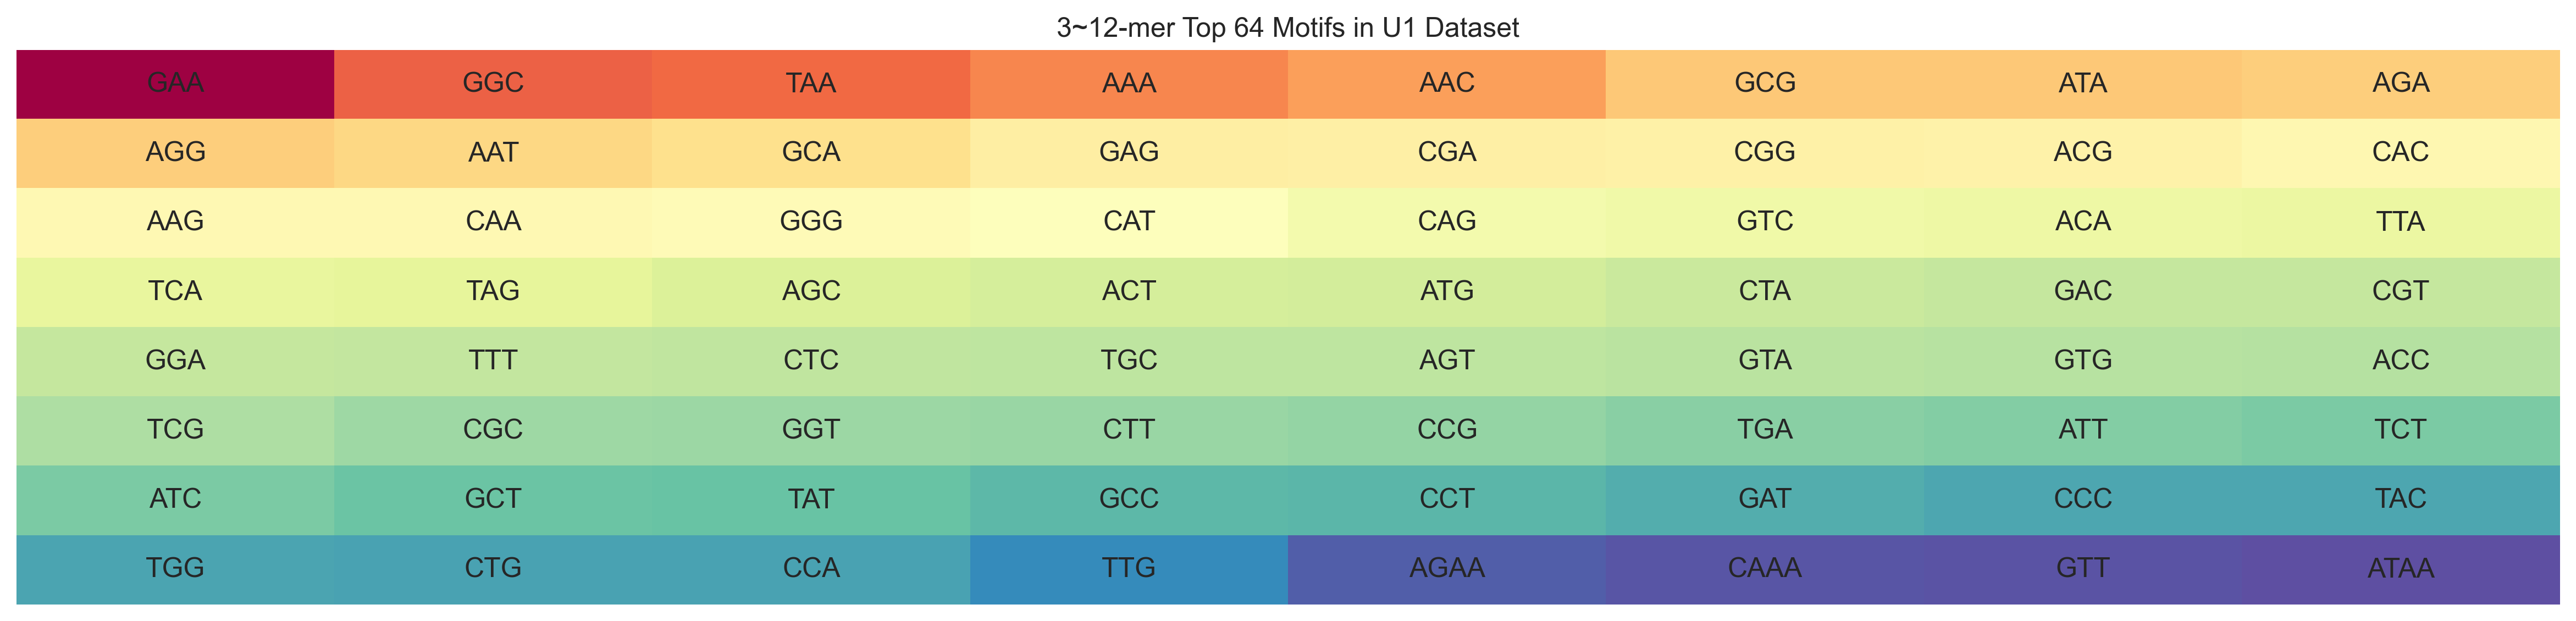

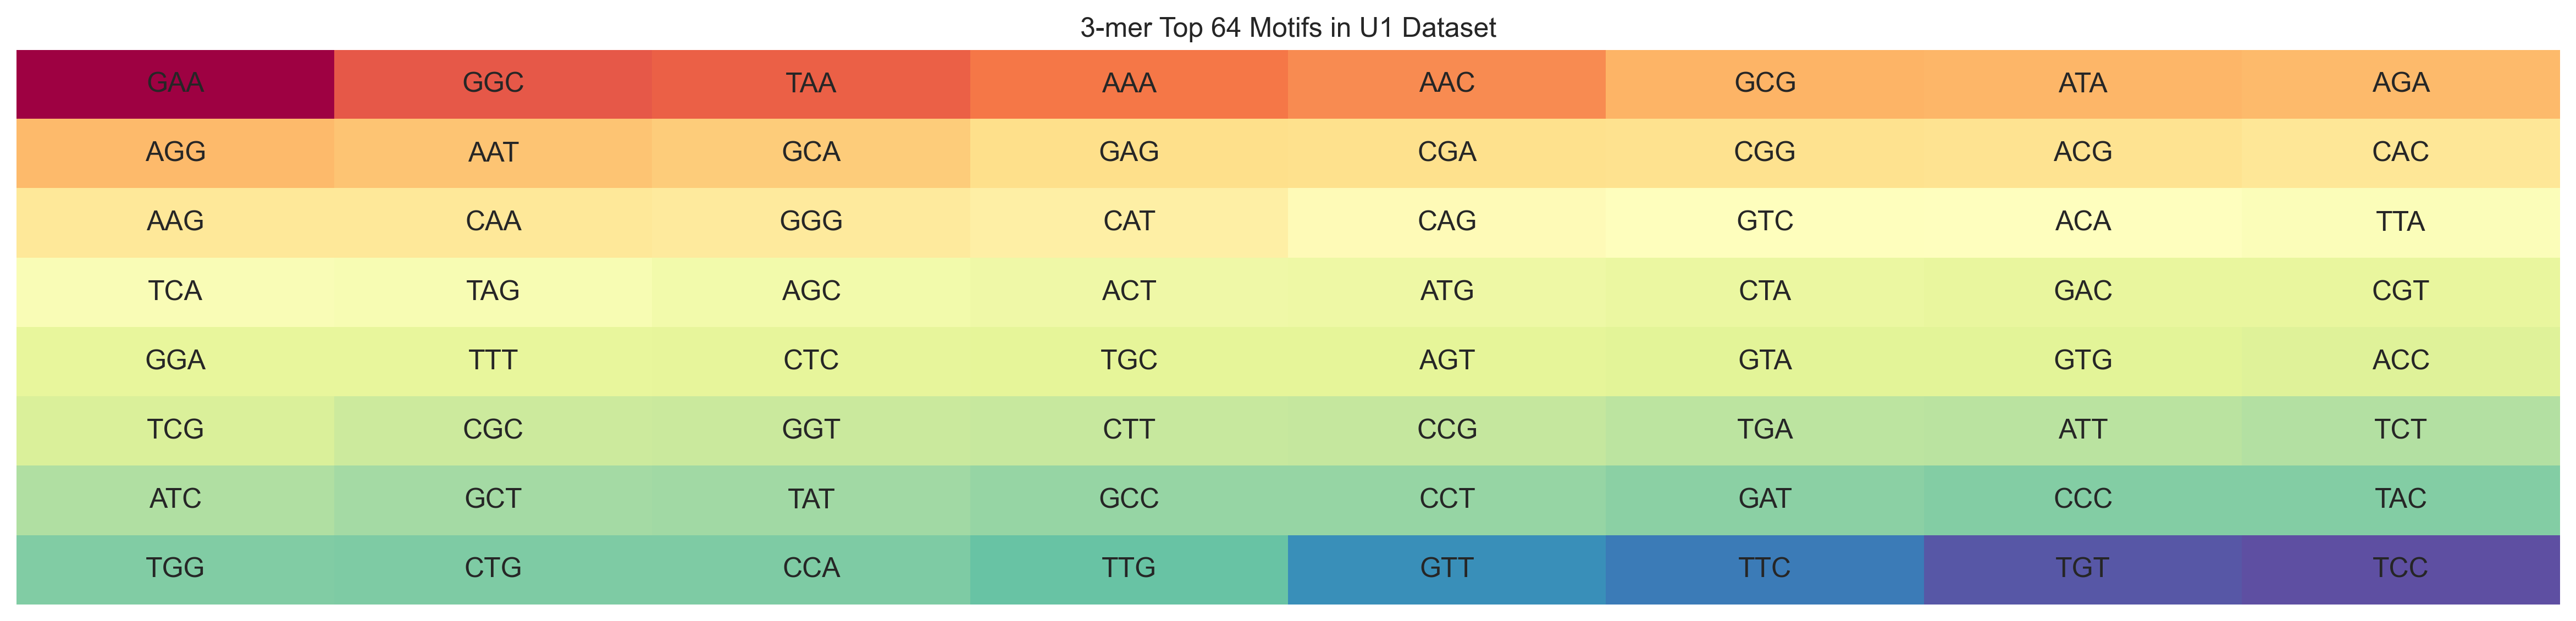

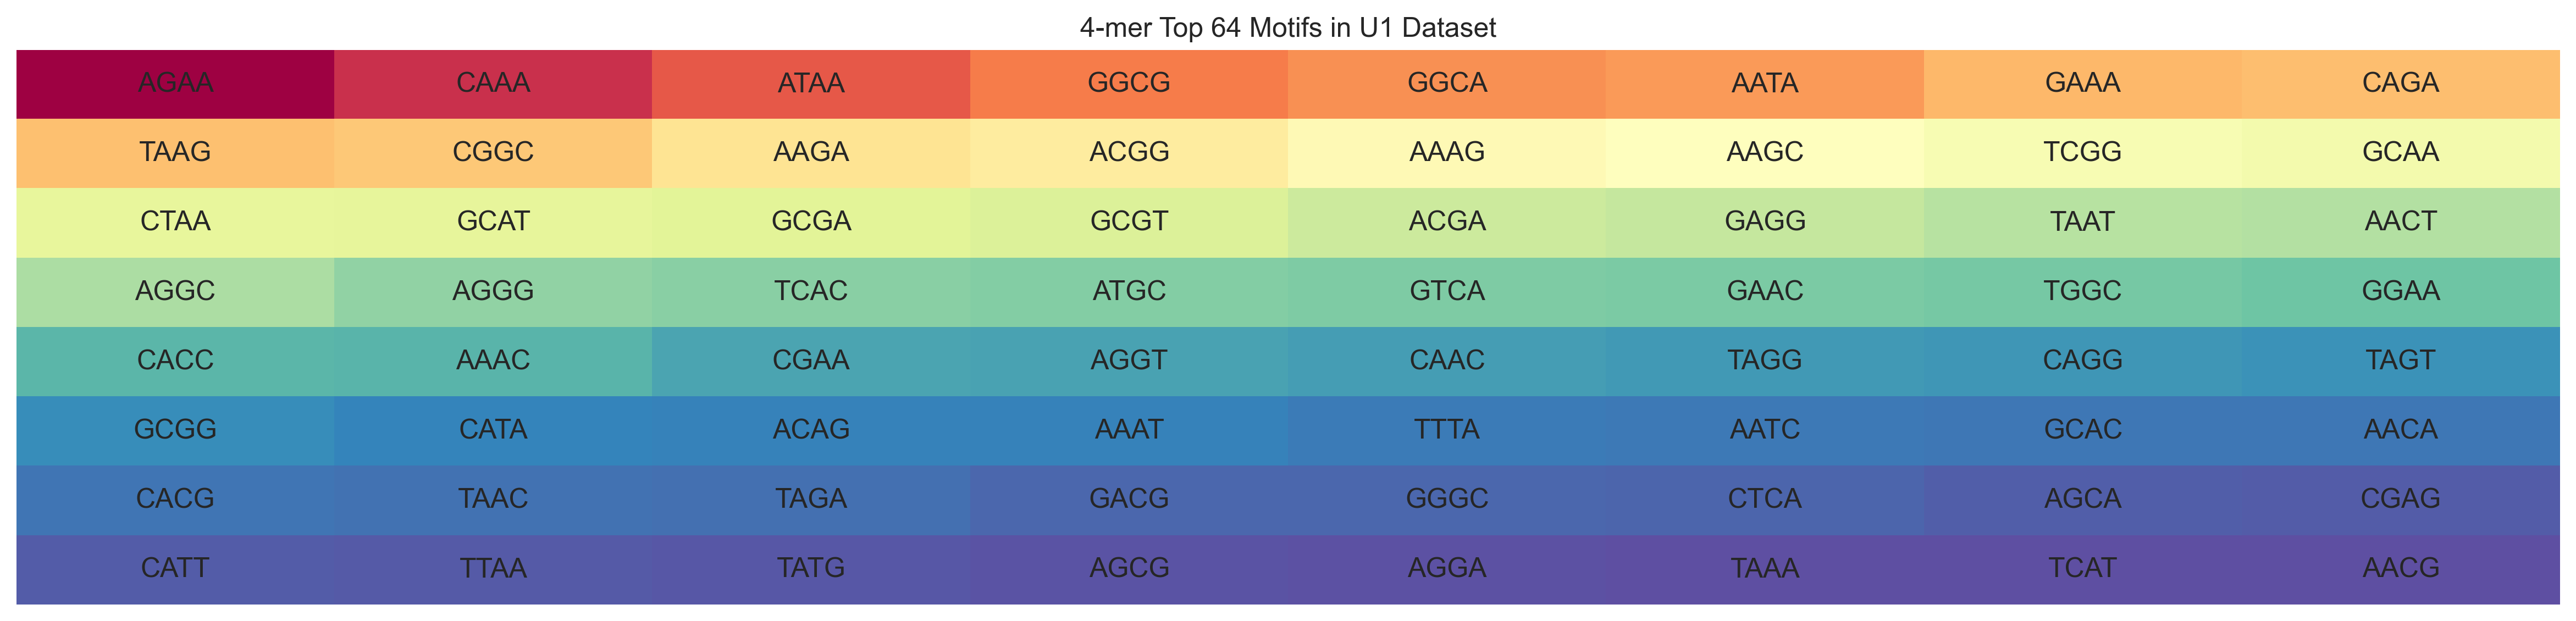

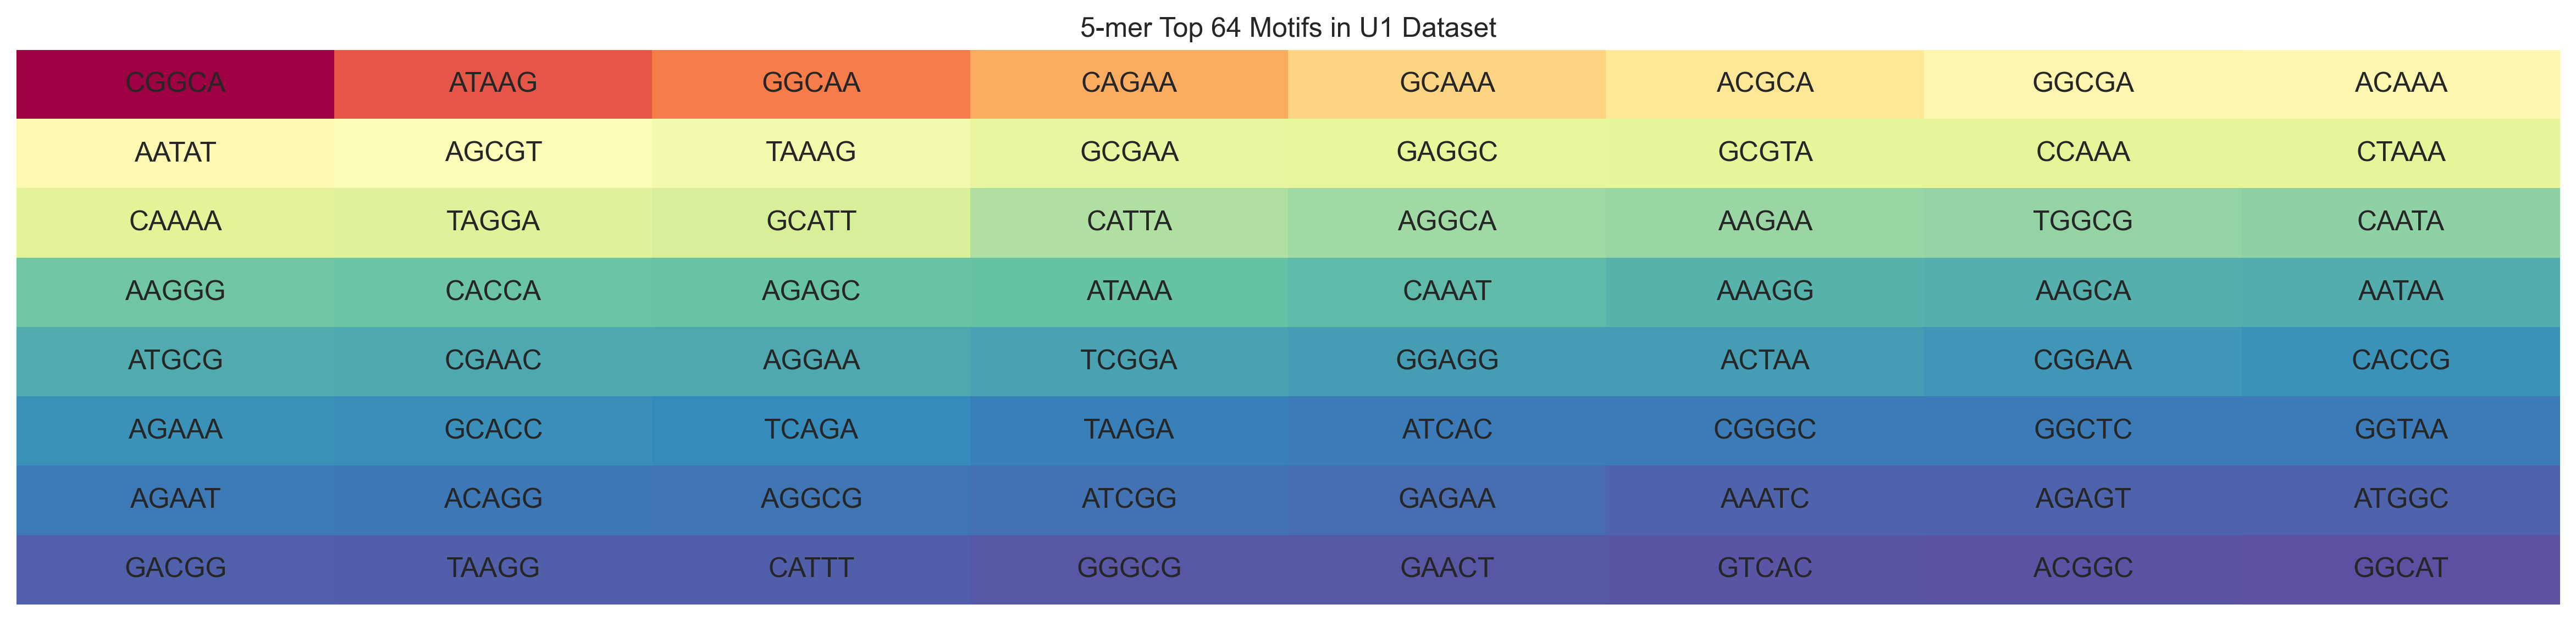

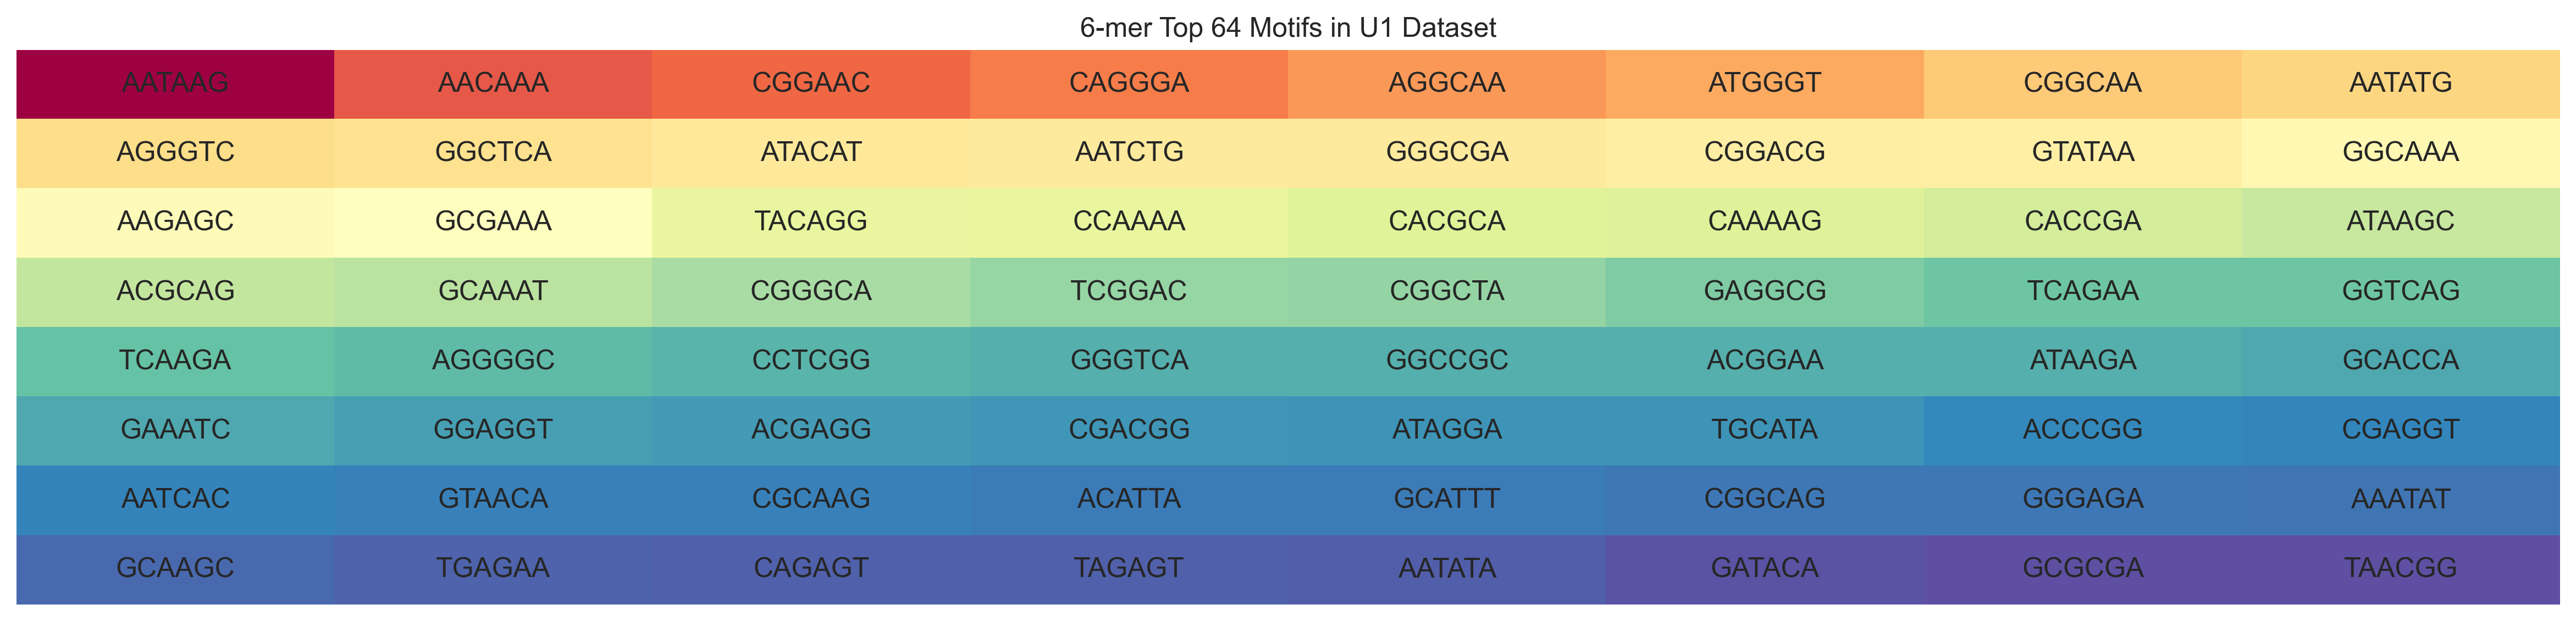

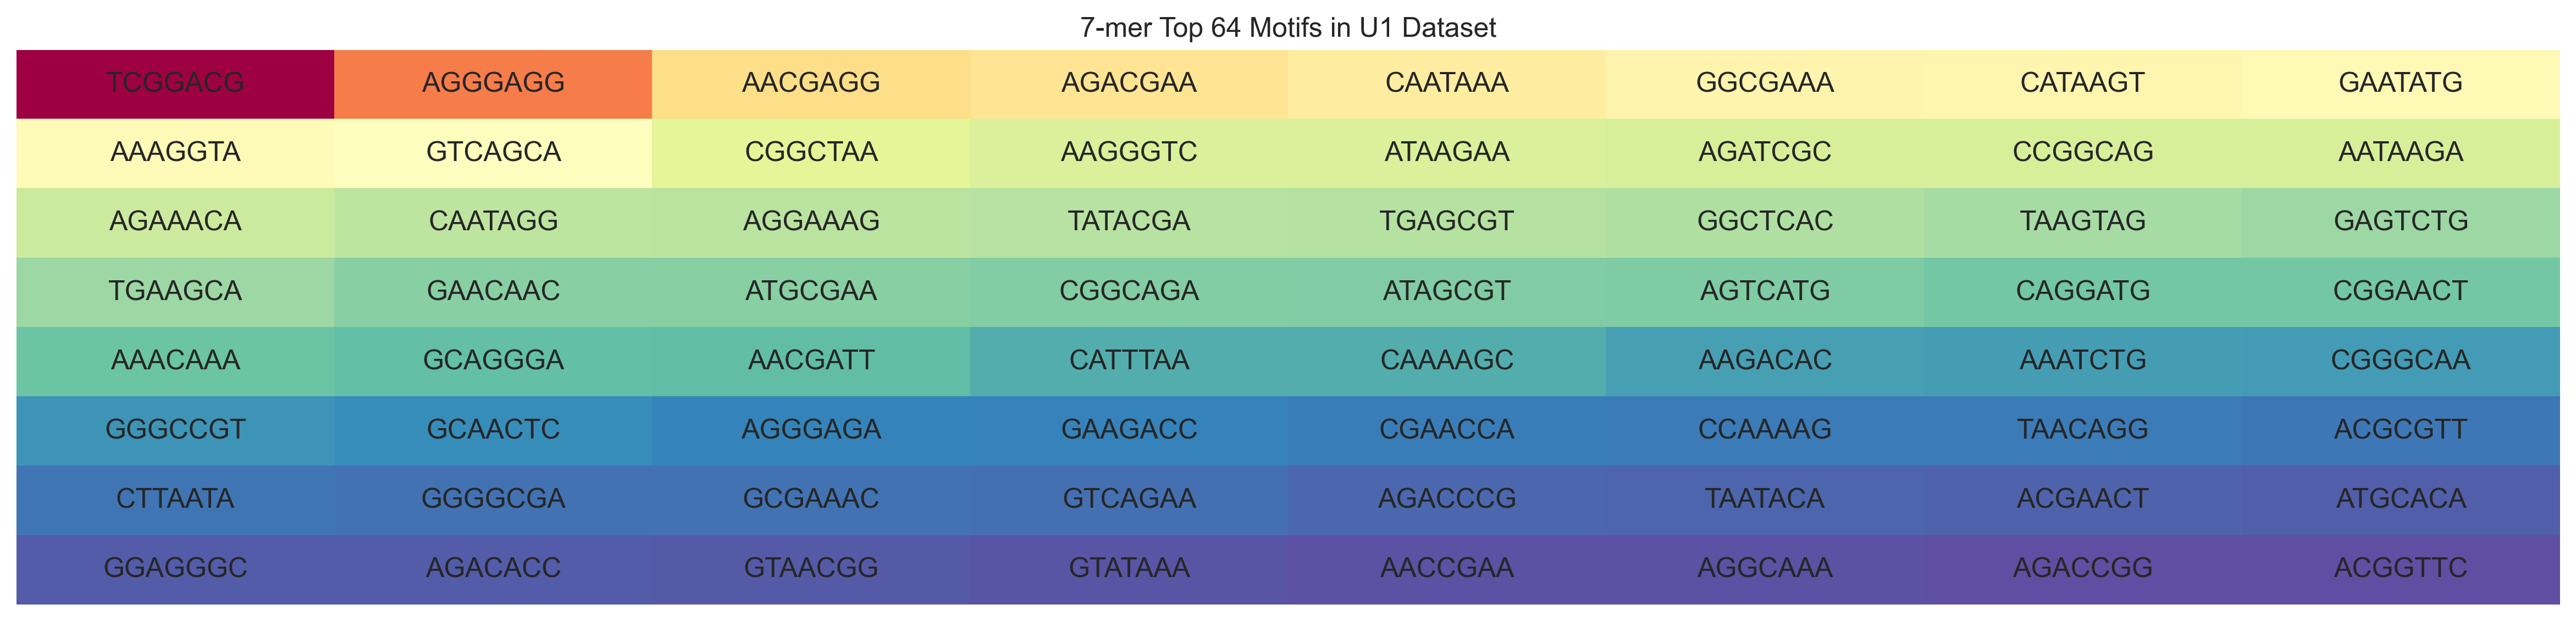

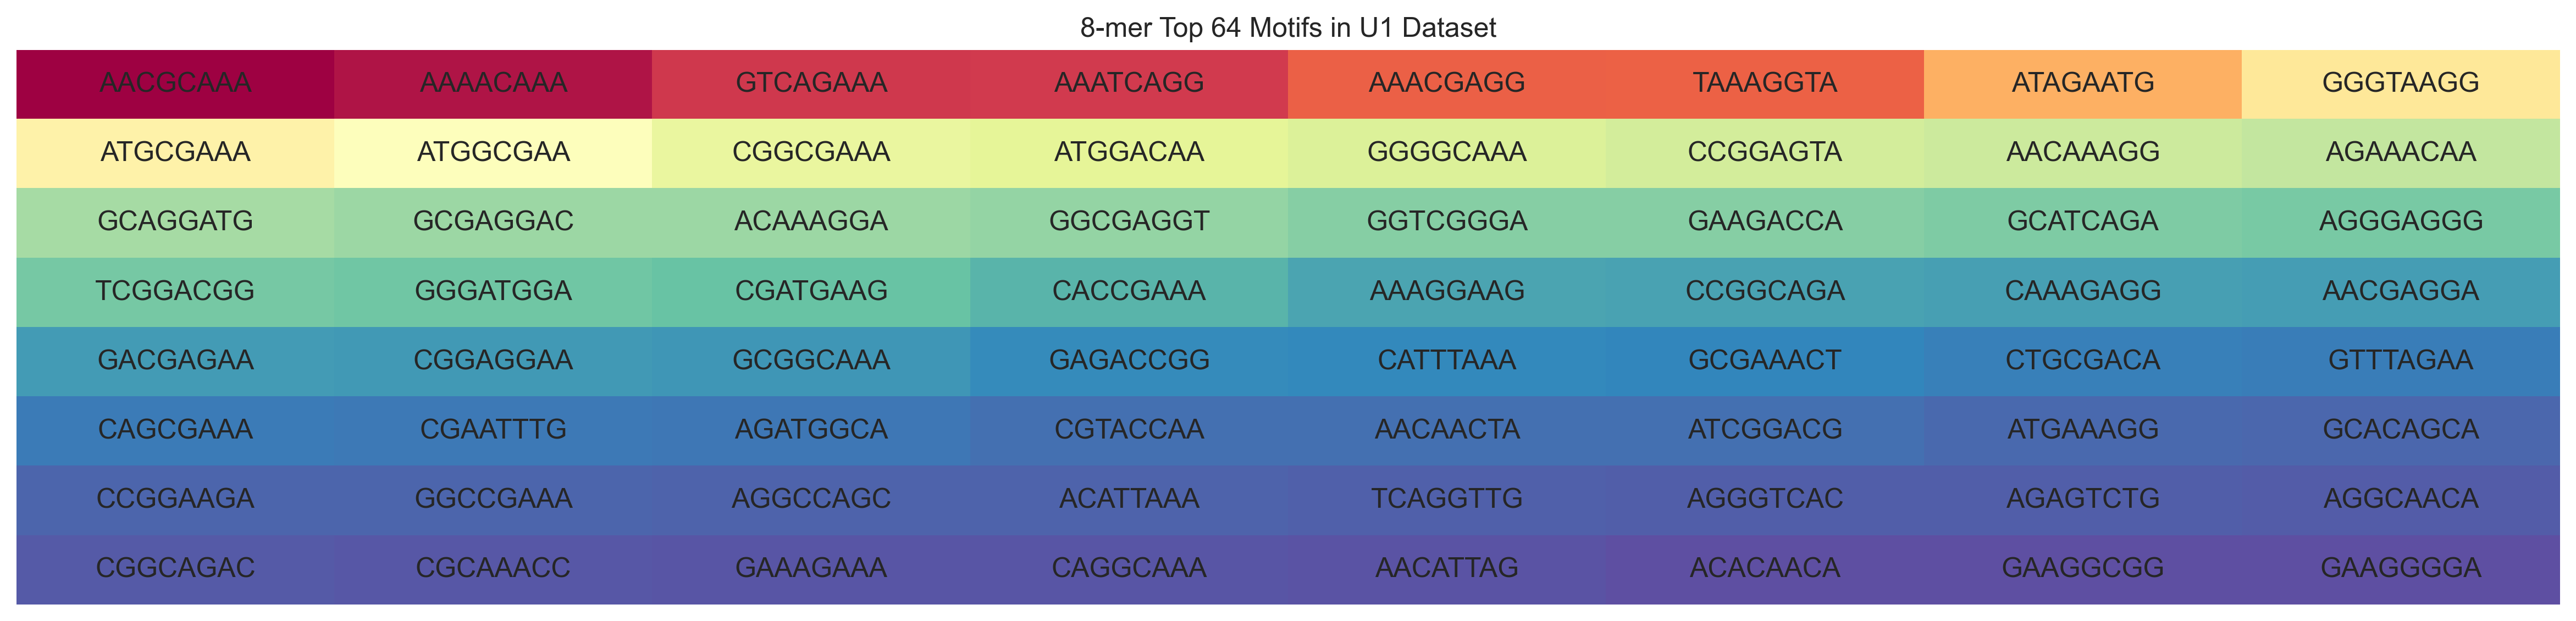

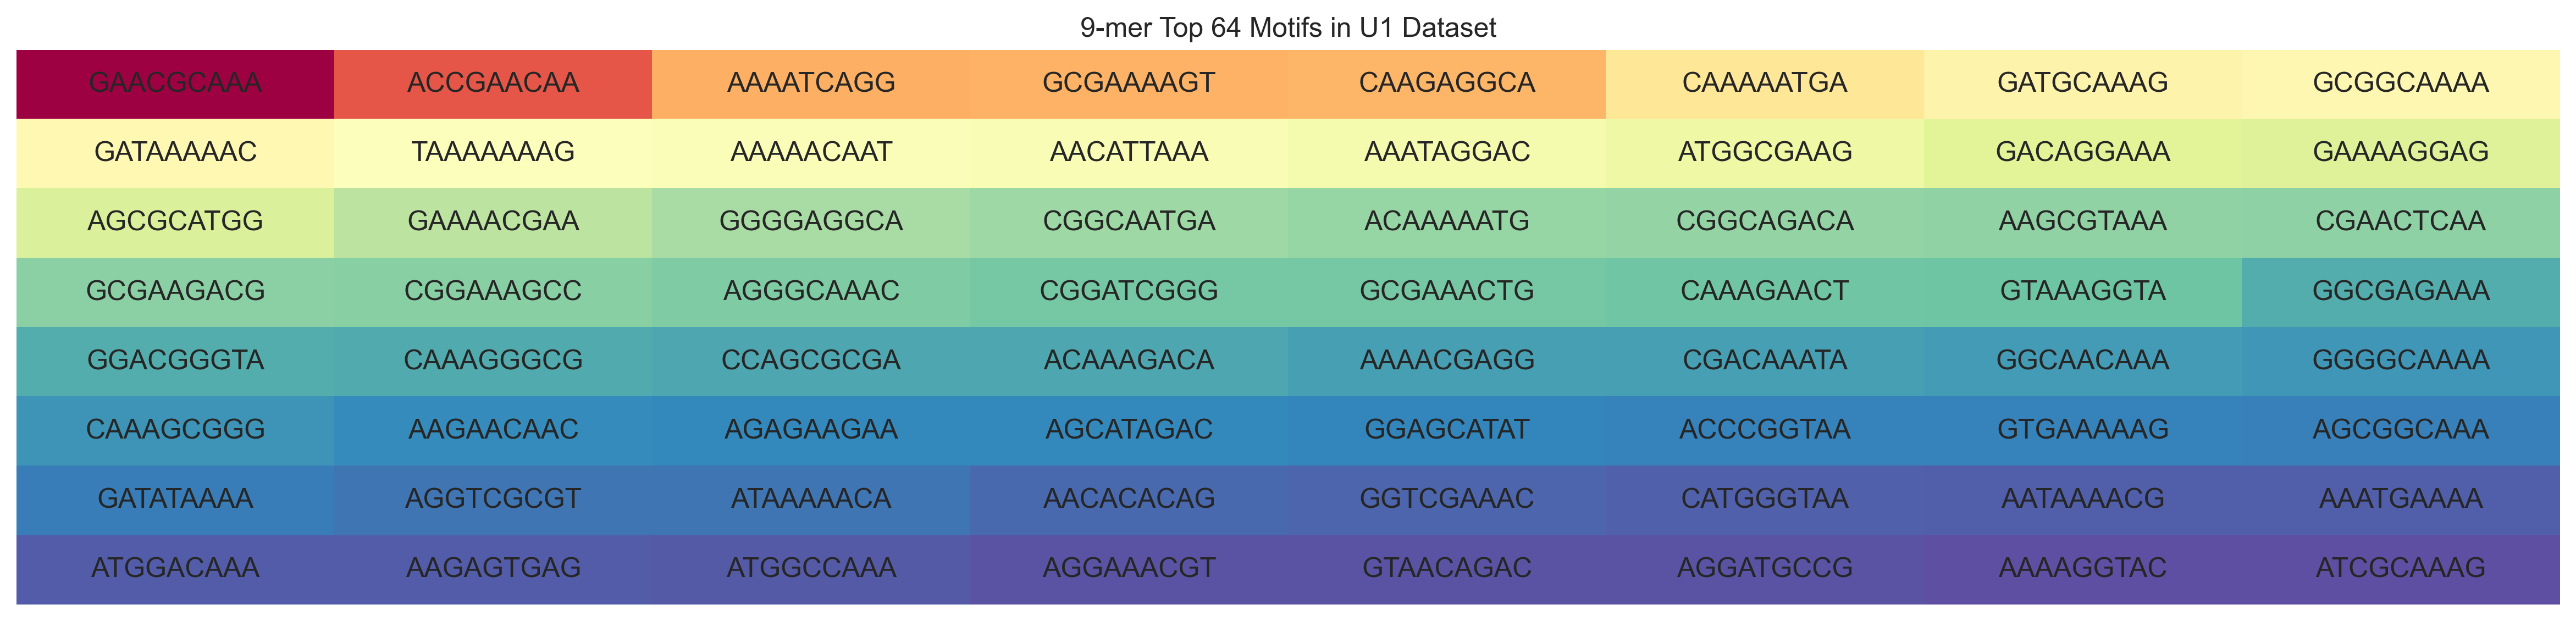

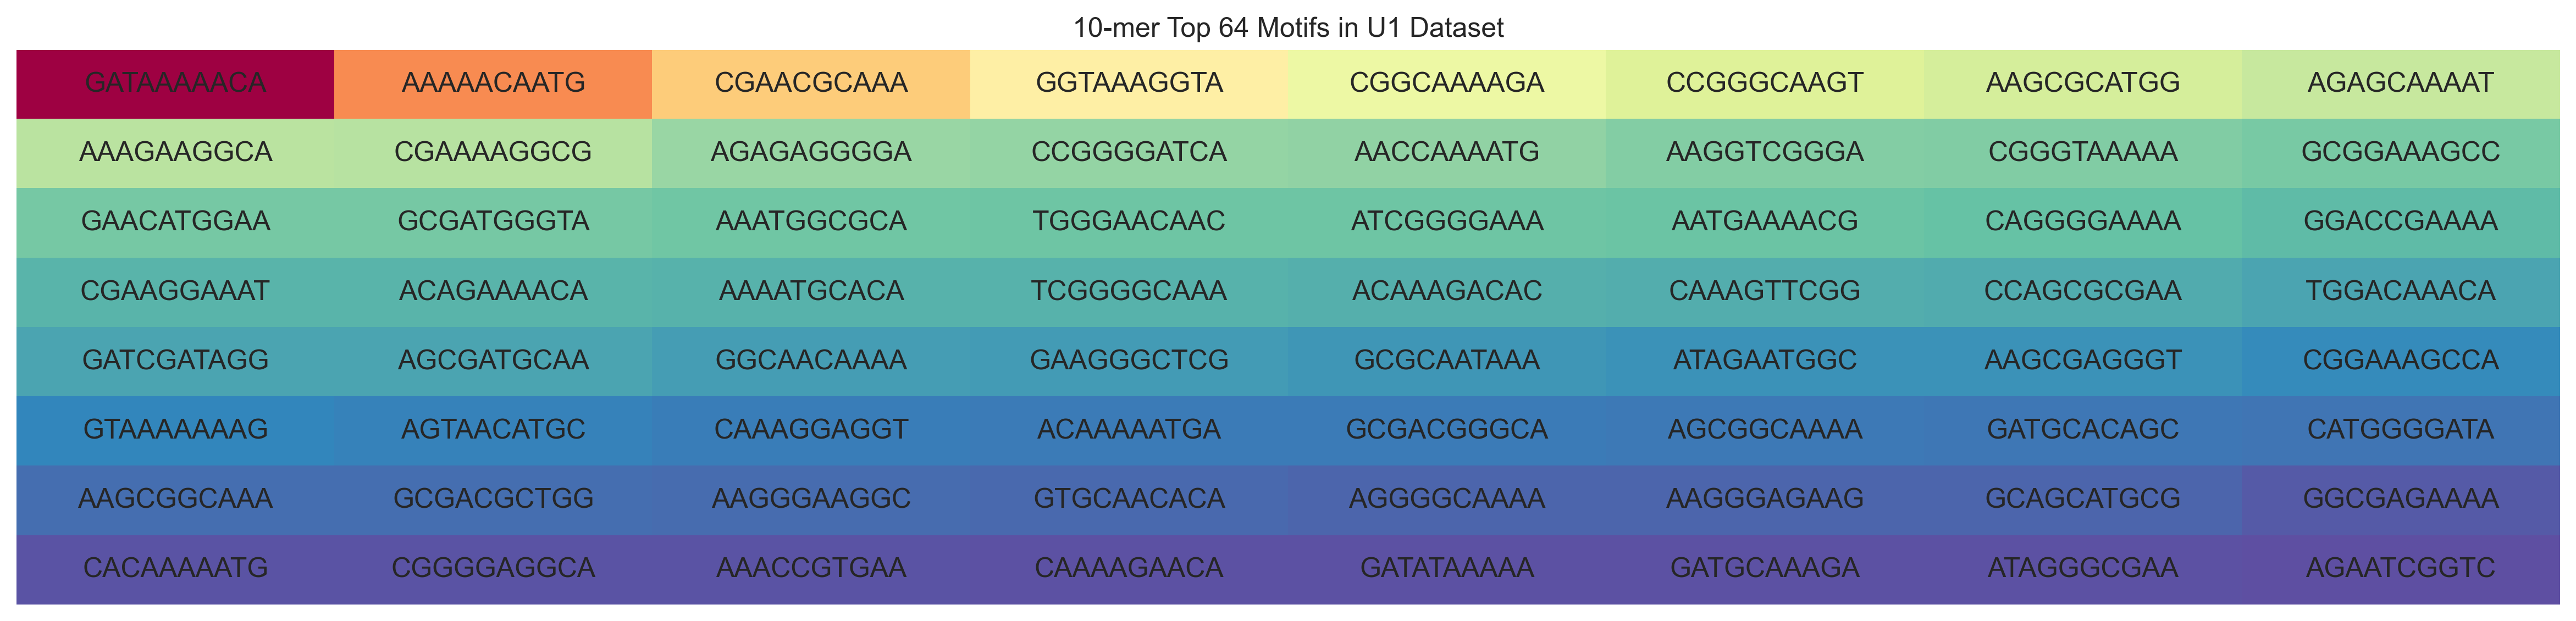

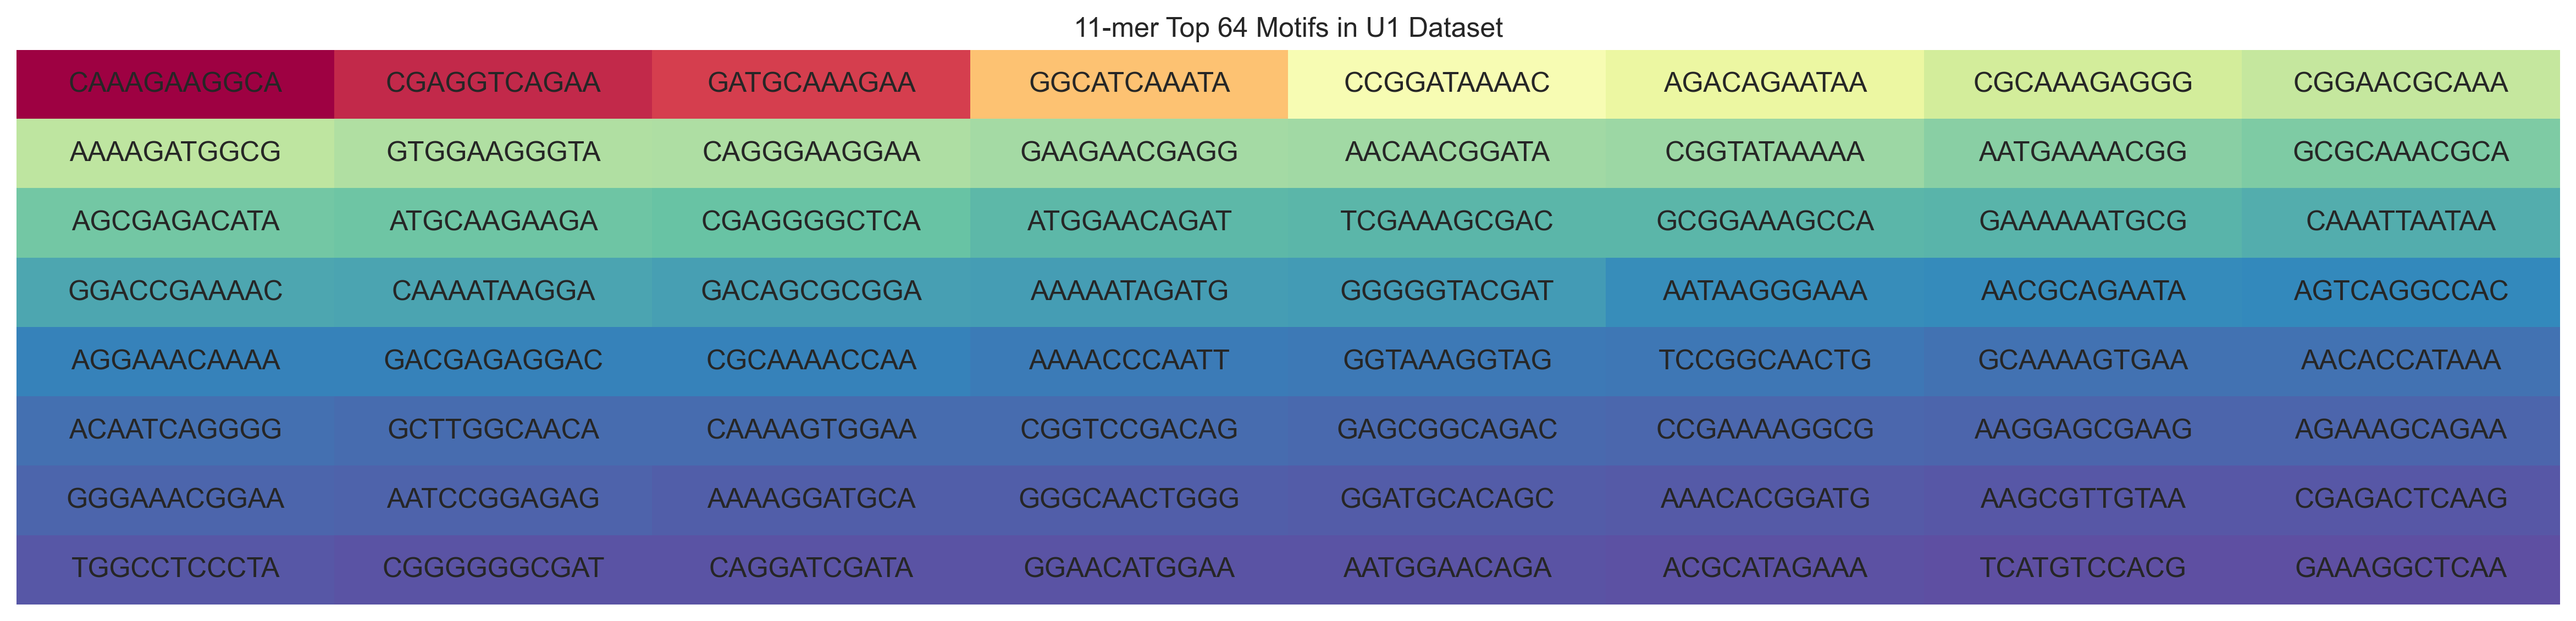

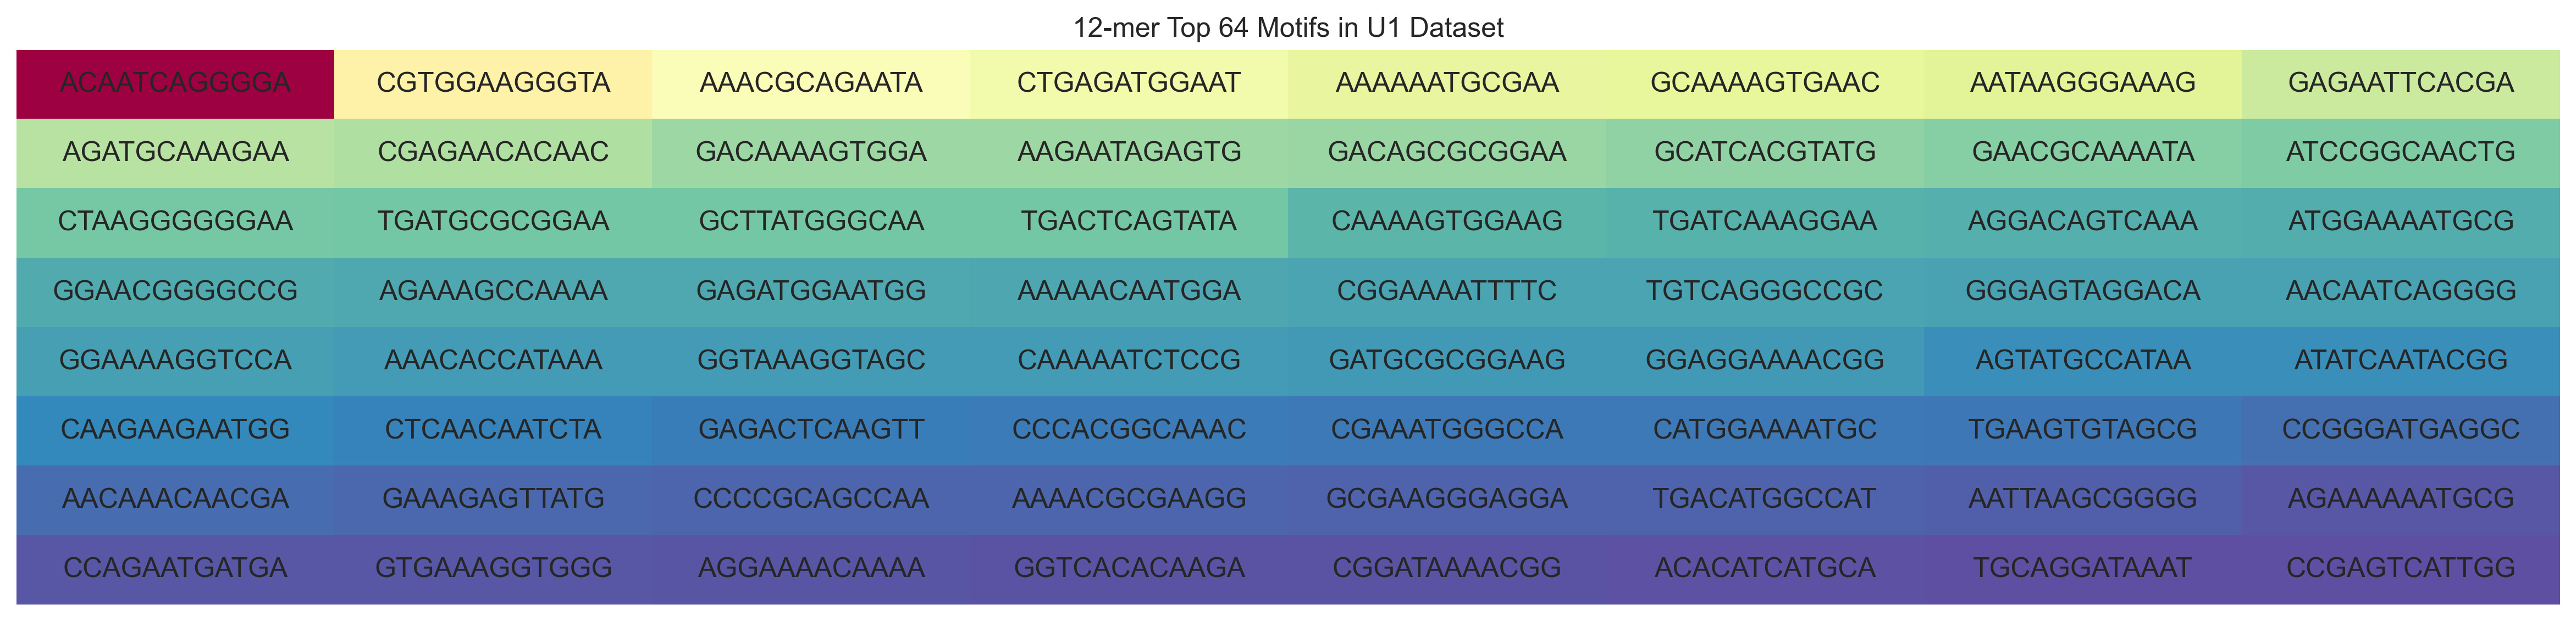

In [109]:
top_n = 8
cmap = matplotlib.cm.Spectral_r
for i, heatmap_motif in enumerate(heatmap_motifs):
    fig, ax = plt.subplots(figsize = (top_n*2, top_n/2), dpi = 300)
    n = [list(motif_length.keys())[i], '3~12'][list(motif_length.keys())[i] == -1]
    heatmap_k, heatmap_v = [item[0] for item in heatmap_motif], [item[1] for item in heatmap_motif]
    im, cbar = heatmap(np.array(heatmap_v).reshape(top_n, top_n), ax = ax, cmap = cmap, cbarlabel = "The number of non-redundant peptide ligands for each HLA allotypes")
    texts = annotate_heatmap(im, reshape_list_tangular(heatmap_k, top_n), np.array(heatmap_v).reshape(top_n, top_n), valfmt="{x}")
    fig.tight_layout()
    plt.title(f'{n}-mer Top {top_n**2} Motifs in U1 Dataset')
    cbar.remove()
    plt.axis('off')
    plt.show()
    #break

# position

In [110]:
attn.shape

(280000, 50, 50)

In [111]:
seqs

['CCGGCTATAGCGCGCAGTGCTCGGATGGCAAGGCGTTCAACCGTGACCAC',
 'AATGGGTACCGTATGTCAAAGGAACCATAGGCGCGGTCGTAGTGGACTCA',
 'CCGCGGCATGATCAAACGGTCTAGATCATAATGCGAGGTCAGTACCACTA',
 'GTGTAAGGCTCTGGTGGGCACACGTCGGTTTGCAGTAATGACAGACACGT',
 'CCGGAAAATCGCGCAAGTCTCCCTTACGAATAAAGCTCAAAGGGAACGTC',
 'CCCAAGCTTGTGGTGCCAGCGAGCAGGCGCAAATGCGGCACAGACCAAGA',
 'GCCGTACTCACAGCAAGATAGCGCGCGTCAATATTGGTCAATGATGCGGC',
 'ACAGCGGCCCCGATCAGCGCTTACGCGACGCGAATCGCTATCCGGTCGAG',
 'CATACAGAAAAAGTAGACTTAAGGTGCAGCTAATCTTGCCATTGGATAAA',
 'AGCGGACTATGCGAGCGATCGGAGTTGTTCGTGGTGCGATAATATCAGTA',
 'AATTCAACAATGGCAGGAGTCTGTGCAAGGGAGGCAGGCTACACTCTGTG',
 'AGGCCTTTCTCCACTACTAAAGATCGAGTTAGGGAATTAACAAGAAAAGA',
 'CCGCACCTTCGTCAGCCATACTTTAGCATCCCGGAAACGGCAGTCCAATC',
 'GATCTCCGGGTAACCTGAGATGTCATGAACACGGCACGAAGCGTGGGAAA',
 'CATGGACCCATACGAGACGTAGGTTTAACCTTCAAAGTCCGGACAGGCTG',
 'CCGGACTATCCACAAGGGGTAGAGAGGTAAGAGCAGAACTTACGCTATTC',
 'TATAGATGATAATTATGATTTCCAACATTTGTCTGGACCGTATTCTGATA',
 'CACACAGTACCACAGCTGTAAGCCATGATGACAAGCCGTGATCGTTCAAA',
 'TTAGATAC

# NucType-Position

In [26]:
def attn_HLA_length_aatype_position_num(data, attn_data, hla = 'HLA-A*11:01', label = None, length = 9, show_num = False):
    aatype_position = dict()
    if label == None:
        length_index = np.array(data[data.length == length][data.HLA == hla].index)
    else:
        length_index = np.array(data[data.length == length][data.HLA == hla][data.label == label].index)

    length_data_num = len(length_index)

    for head in range(9):
        for idx in length_index:
            temp_peptide = data.iloc[idx].peptide
            temp_length_head = deepcopy(nn.Softmax(dim=-1)(attn_data[idx][head][:, :length].float())) # Shape = (34, 9), 行是HLA，列是peptide，由行查列
            temp_length_head = nn.Softmax(dim=-1)(temp_length_head.sum(axis = 0)) # 把这一列的数据相加，shape = （9，）

            for i, aa in enumerate(temp_peptide): 
                aatype_position.setdefault(aa, {})
                aatype_position[aa].setdefault(i, 0)
                aatype_position[aa][i] += temp_length_head[i] 
    
    if show_num:
        aatype_position_num = dict()
        for idx in length_index:
            temp_peptide = data.iloc[idx].peptide
            for i, aa in enumerate(temp_peptide):
                aatype_position_num.setdefault(aa, {})
                aatype_position_num[aa].setdefault(i, 0)
                aatype_position_num[aa][i] += 1
             
        return aatype_position, aatype_position_num
    else:
        return aatype_position


In [27]:
nuctype_position = dict()
attn_nuctype_position = deepcopy(torch.Tensor(attn))
attn_nuctype_position = nn.Softmax(dim = -1)(attn_nuctype_position) # 对每个instance取由行查列的attn归一化
attn_nuctype_position = attn_nuctype_position.sum(dim = 1) # 对每个instance的列相加
print(attn_nuctype_position.shape)
for s_i, seq in tqdm(enumerate(seqs)):
    for n_i, nuc in enumerate(seq):
        nuctype_position.setdefault(nuc, {})
        nuctype_position[nuc].setdefault(n_i, 0)
        nuctype_position[nuc][n_i] += attn_nuctype_position[s_i][n_i]


torch.Size([280000, 50])


280000it [01:23, 3347.47it/s]


In [28]:
nuctype_position_pd = np.zeros((4, 50))

nuc_i, nuc_indexs = 0, []
for nuc, nuc_posi in tqdm(nuctype_position.items()):
    nuc_indexs.append(nuc)
    for posi, v in nuc_posi.items():
        nuctype_position_pd[nuc_i, posi] = v
    nuc_i += 1

nuctype_position_pd_unsoftmax = pd.DataFrame(nuctype_position_pd, index = nuc_indexs, columns = range(1, 51))

nuctype_position_pd_softmax = deepcopy(nn.Softmax(dim = -1)(torch.Tensor(nuctype_position_pd)))
nuctype_position_pd_softmax = pd.DataFrame(nuctype_position_pd_softmax, index = nuc_indexs, columns = range(1, 51))

100%|██████████| 4/4 [00:00<00:00, 7884.03it/s]


In [29]:
nuctype_position_pd_unsoftmax

1              2             3             4             5             6             7             8             9             10            11            12            13            14            15            16            17            18            19            20            21            22            23            24            25            26            27            28            29            30            31            32            33            34            35            36            37            38            39            40            41            42            43            44            45            46             47             48             49             50
C  139428.921875  141108.640625  68993.414062  77944.187500  74798.320312  65685.101562  62545.515625  63809.261719  65182.832031  66696.335938  67249.101562  67877.835938  67944.820312  67898.617188  67678.382812  66902.015625  67511.015625  68188.890625  67706.460938  68075.429688  69090.093750  68971.093750  69135.500000  69086.453125  69001.664062  68392.218750  68633.046875  67453.875000  66532.015625  67033.281250  66983.617188  66209.859375  67632.148438  68359.820312  66871.945312  67402.101562  66295.453125  66498.750000  68044.000000  69320.078125  68594.335938  66317.945312  67025.398438  66508.960938  66624.187500  65913.820312   78082.273438   73230.625000   82873.390625   50880.480469
G   58980.937500   90981.343750  98485.875000  96085.062500  92853.054688  72787.609375  69091.242188  70512.937500  68472.992188  68660.898438  68443.742188  68540.570312  67739.828125  67295.703125  67620.335938  67710.351562  67651.375000  67620.898438  66281.945312  64575.433594  65226.183594  64926.140625  64351.171875  65114.269531  64598.683594  63820.406250  65780.734375  67785.328125  68888.406250  69338.789062  69232.601562  67340.890625  68254.695312  69422.460938  69290.281250  69351.062500  68816.320312  66000.242188  65926.609375  67823.585938  67000.390625  67732.109375  66746.601562  65976.078125  66742.101562  66813.851562   74571.281250   69339.679688   70245.570312   49529.597656
T   39297.613281   50335.449219  56392.121094  60940.804688  58510.757812  53434.132812  51909.523438  53181.964844  54568.406250  53943.578125  55320.812500  55407.695312  53802.273438  54928.820312  55158.914062  55675.640625  55731.554688  56364.625000  54477.968750  55895.335938  56318.164062  55916.832031  56145.167969  56482.808594  54506.226562  53185.031250  55882.136719  54179.605469  53718.296875  52822.710938  51797.652344  48578.191406  53005.148438  52702.777344  53155.042969  52684.804688  52718.984375  48322.644531  51853.976562  52871.710938  53835.734375  53339.359375  53869.773438  53568.316406  56437.902344  56790.937500   67348.921875   66590.437500   80329.367188   49050.074219
A   50800.863281   80687.109375  86813.562500  98175.023438  94715.570312  81779.593750  76851.898438  79023.679688  78353.453125  79074.968750  78999.023438  80023.914062  80216.789062  80084.664062  79733.195312  80138.304688  79957.976562  80342.476562  79647.843750  80894.789062  81708.335938  82320.414062  82075.648438  81937.835938  81248.562500  80924.351562  82437.617188  83160.179688  82838.742188  83990.000000  83644.507812  81953.187500  85181.828125  85355.796875  84940.960938  84638.273438  83423.734375  81271.945312  82366.125000  84123.320312  84795.242188  84555.945312  85635.937500  85445.554688  87454.656250  90725.039062  109672.757812  114069.000000  131023.601562  104874.179688

In [30]:
nuctype_position_pd_softmax

1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50
C  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
G  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
T  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0

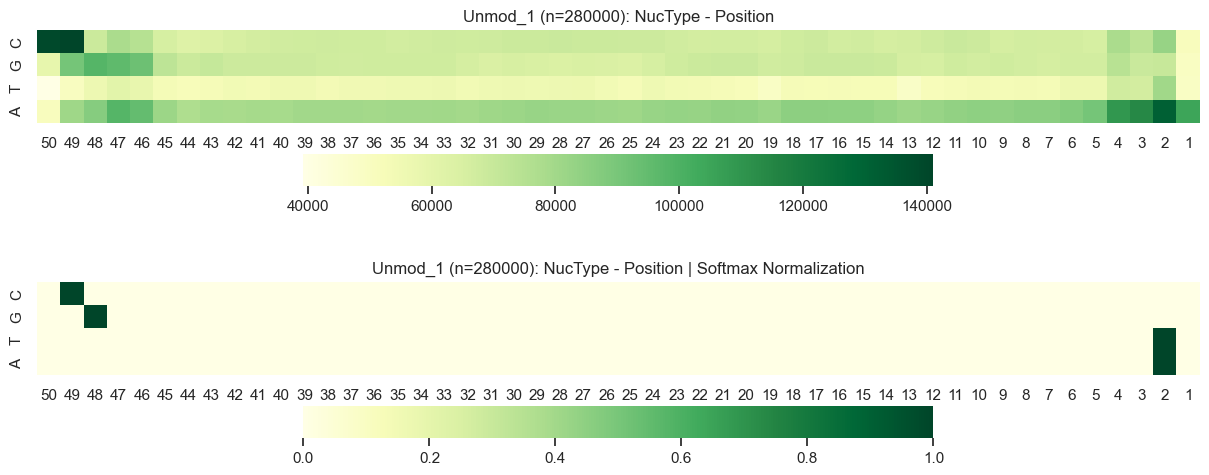

In [38]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 6))
cmap = 'YlGn'
sns.heatmap(nuctype_position_pd_unsoftmax, xticklabels = range(50, 0, -1),
            ax = axes[0], cmap = cmap, square = True, cbar = False)
norm_unsoftmax = mpl.colors.Normalize(vmin = nuctype_position_pd_unsoftmax.values.min(),
                                    vmax = nuctype_position_pd_unsoftmax.values.max())
cbar_unsoftmax = fig.colorbar(mpl.cm.ScalarMappable(norm = norm_unsoftmax, cmap = cmap),
                            orientation = 'horizontal', ax = axes[0])
cbar_unsoftmax.outline.set_visible(False)
axes[0].set_title('Unmod_1 (n=280000): NucType - Position')


sns.heatmap(nuctype_position_pd_softmax, xticklabels = range(50, 0, -1),
            ax = axes[1], cmap = cmap, square = True, cbar = False)

norm_softmax = mpl.colors.Normalize(vmin = nuctype_position_pd_softmax.values.min(),
                                    vmax = nuctype_position_pd_softmax.values.max())
cbar_softmax = fig.colorbar(mpl.cm.ScalarMappable(norm = norm_softmax, cmap = cmap),
                            orientation = 'horizontal', ax = axes[1])
cbar_softmax.outline.set_visible(False)
axes[1].set_title('Unmod_1 (n=280000): NucType - Position | Softmax Normalization')

plt.show()

# positional

In [34]:
# positional
attn_position = deepcopy(torch.Tensor(attn))
attn_position = nn.Softmax(dim = -1)(attn_position) # 对每个instance取由行查列的attn归一化
attn_position = attn_position.sum(dim = 0) # 对所有instance的attn相加
attn_position = np.array((attn_position.sum(axis = 0)))# 把这一列的数据相加
print(attn_position.shape)

(50,)


/tmp/ipykernel_91046/1864705185.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap),


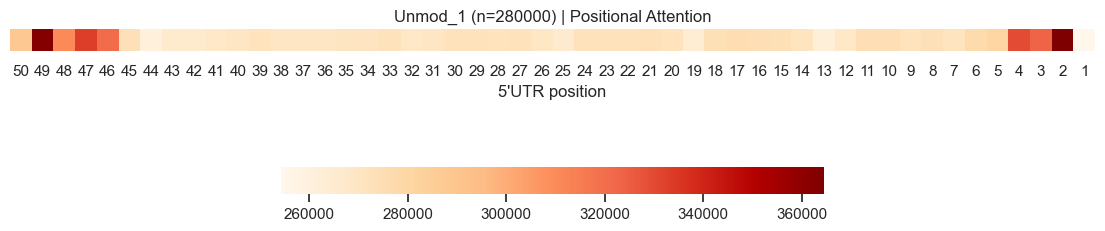

In [37]:
# draw_eachlength_head_pepposition(sum_peplength_pepposition, label, savepath = False)
fig = plt.figure()

cmap = 'OrRd'
sns.heatmap(attn_position.reshape(-1, 1).T, cmap = cmap, cbar = False, square = True,
            xticklabels = range(50, 0, -1), yticklabels = '')

plt.title('Unmod_1 (n=280000) | Positional Attention')
plt.xlabel("5'UTR position")
plt.ylabel('')

norm = mpl.colors.Normalize(vmin = min(attn_position), vmax = max(attn_position))
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), 
                    orientation='horizontal', shrink = 0.5) # , anchor = (-0.2, 0.5)
cbar.outline.set_visible(False)

plt.show()